In [35]:
# For Google Colab 
#!git clone https://github.com/Mikolaj-MLP/NLP-Sentiment-IMDB-reviews.git
#import sys
#sys.path.append('/content/NLP-Sentiment-IMDB-reviews')

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [3]:
train_path = os.getenv("TRAIN_PATH")
test_path = os.getenv("TEST_PATH")
valid_path = os.getenv("VALID_PATH")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
valid = pd.read_csv(valid_path)

In [4]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
def print_wrapped_text(text, words_per_line):
    words = text.split()
    for i in range(0, len(words), words_per_line):
        print(" ".join(words[i:i + words_per_line]))

In [6]:
row = 1
text = f"{train['text'][row]}\nSentiment: {train['label'][row]}"
print_wrapped_text(text, 25)

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping
that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a
kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I
might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it
primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the
display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and
the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The
actual drawings isnt that bad, b

In [7]:
print(train.shape)
print(test.shape)
print(valid.shape)

column = "label"
print("\nunique labels :", train[column].unique(), valid[column].unique(), test[column].unique())

print("\nnull count : \n", train.isnull().sum(), valid.isnull().sum(), test.isnull().sum())

(40000, 2)
(5000, 2)
(5000, 2)

unique labels : [0 1] [0 1] [0 1]

null count : 
 text     0
label    0
dtype: int64 text     0
label    0
dtype: int64 text     0
label    0
dtype: int64


Data Preprocessing

In [8]:
from utils.data_preprocessor import DataPreprocessor

In [9]:
preprocessor = DataPreprocessor(remove_stopwords=True, use_stemming=True)

In [10]:
train_processed, valid_processed, test_processed = preprocessor.process((train, valid, test))

In [11]:
all_tokens = [token for row in train_processed['processed_text'] for token in row]

word_freq = Counter(all_tokens)
unique_words = len(word_freq)
vocab_size = len(set(all_tokens))

In [12]:
train_processed

,processed_text,label
0,"[grew, b, watch, love, thunderbird, mate, scho...",0
1,"[put, movi, dvd, player, sat, coke, chip, expe...",0
2,"[peopl, know, particular, time, past, like, fe...",0
3,"[even, though, great, interest, biblic, movi, ...",0
4,"[im, die, hard, dad, armi, fan, noth, ever, ch...",1
...,...,...
39995,"[western, union, someth, forgotten, classic, w...",1
39996,"[movi, incred, piec, work, explor, everi, nook...",1
39997,"[wife, watch, movi, plan, visit, sicili, strom...",0
39998,"[first, watch, flatlin, amaz, necessari, featu...",1


Data Analysis

In [13]:
print(train_processed['processed_text'].apply(len).mean())

118.1877


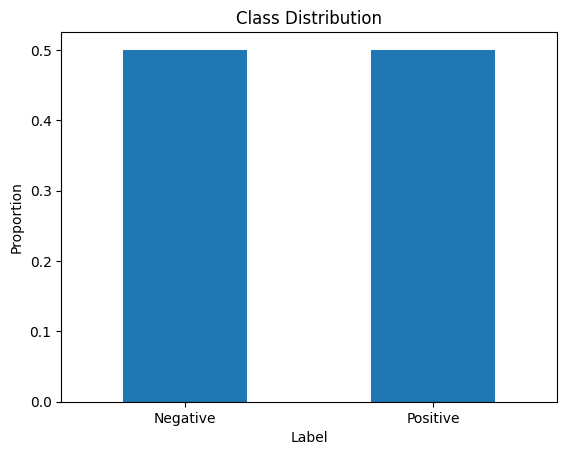

In [14]:
train_processed['label'].value_counts(normalize=True).plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.show()

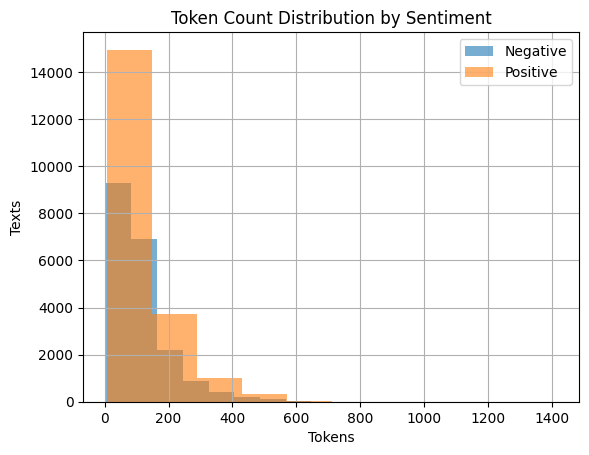

In [15]:
train_processed['length'] = train_processed['processed_text'].apply(len)

train_processed[train_processed['label'] == 0]['length'].hist(alpha=0.6, label='Negative')
train_processed[train_processed['label'] == 1]['length'].hist(alpha=0.6, label='Positive')
plt.legend()
plt.title("Token Count Distribution by Sentiment")
plt.xlabel("Tokens")
plt.ylabel("Texts")
plt.show()

In [16]:
def top_words_for_label(label, n=15):
    tokens = train_processed[train_processed['label'] == label]['processed_text'].explode()
    return Counter(tokens).most_common(n)

print("Positive (label=1):", top_words_for_label(1))
print("Negative (label=0):", top_words_for_label(0))

Positive (label=1): [('film', 40687), ('movi', 36010), ('one', 22660), ('like', 16602), ('time', 13326), ('good', 12221), ('see', 12180), ('charact', 11332), ('stori', 11324), ('make', 11135), ('great', 10500), ('well', 10473), ('watch', 10313), ('get', 10257), ('love', 10105)]
Negative (label=0): [('movi', 46777), ('film', 36001), ('one', 21722), ('like', 19715), ('make', 12977), ('even', 12371), ('time', 12320), ('get', 12222), ('good', 12051), ('watch', 11980), ('bad', 11781), ('charact', 11402), ('would', 11185), ('see', 10436), ('realli', 9899)]


In [17]:
#junk seeking, here we examine the validity of the cleaning process to make sure some illogical symbols have not remained
print("Bottom 10 Words by Frequency:", word_freq.most_common()[-10:])

rare_words = [(word, count) for word, count in word_freq.items() if count < 5]
print(f"Rare Words (<5 occurrences): {len(rare_words)}")
print("Sample:", rare_words[:10])

Bottom 10 Words by Frequency: [('aaghh', 1), ('hyller', 1), ('entirelli', 1), ('igeni', 1), ('csiko', 1), ('puszta', 1), ('paedophiliac', 1), ('amnes', 1), ('golthwait', 1), ('onso', 1)]
Rare Words (<5 occurrences): 39781
Sample: [('jonatha', 1), ('subsp', 1), ('videoshop', 1), ('schoobi', 3), ('nuttin', 2), ('moonland', 1), ('ipso', 1), ('audiobook', 1), ('mcneali', 3), ('microsystem', 1)]


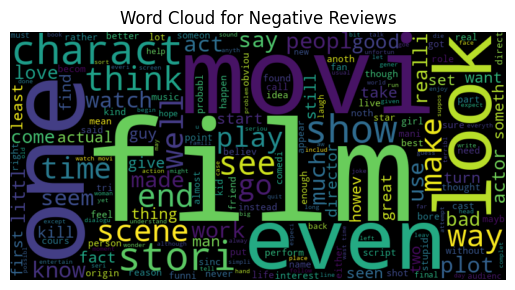

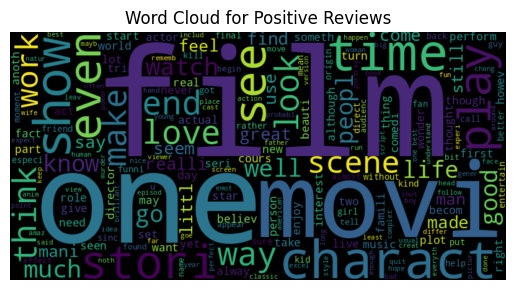

In [18]:
for label in [0, 1]:
    tokens = train_processed[train_processed['label'] == label]['processed_text']
    flat = " ".join([token for row in tokens for token in row])
    wordcloud = WordCloud(width=800, height=400).generate(flat)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {'Negative' if label==0 else 'Positive'} Reviews")
    plt.show()

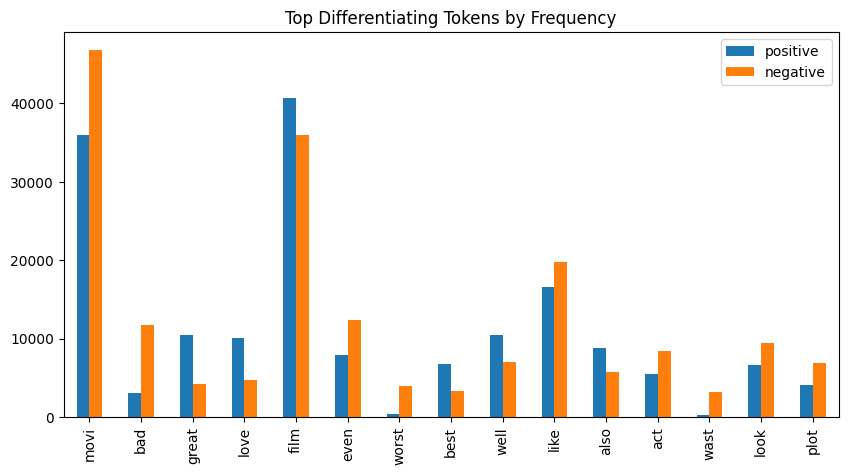

In [19]:
positive_counts = Counter([t for row in train_processed[train_processed['label'] == 1]['processed_text'] for t in row])
negative_counts = Counter([t for row in train_processed[train_processed['label'] == 0]['processed_text'] for t in row])

df_freq = pd.DataFrame({
    'positive': dict(positive_counts),
    'negative': dict(negative_counts)
}).fillna(0)

df_freq['diff'] = df_freq['positive'] - df_freq['negative']
top_diff = df_freq['diff'].abs().sort_values(ascending=False).head(15)

df_freq.loc[top_diff.index][['positive', 'negative']].plot(kind='bar', figsize=(10, 5))
plt.title("Top Differentiating Tokens by Frequency")
plt.show()

In [20]:
def get_ngrams_for_label(label, n=2):
    tokens = [token for row in train_processed[train_processed['label'] == label]['processed_text'] for token in row]
    n_grams = ngrams(tokens, n)
    return Counter(n_grams).most_common(10)

print("Positive Bigrams:", get_ngrams_for_label(1, 2))
print("Negative Bigrams:", get_ngrams_for_label(0, 2))

Positive Bigrams: [(('one', 'best'), 1361), (('watch', 'movi'), 1043), (('even', 'though'), 875), (('year', 'old'), 855), (('see', 'movi'), 826), (('look', 'like'), 782), (('first', 'time'), 778), (('ever', 'seen'), 772), (('highli', 'recommend'), 723), (('main', 'charact'), 688)]
Negative Bigrams: [(('look', 'like'), 2236), (('watch', 'movi'), 1475), (('ever', 'seen'), 1411), (('wast', 'time'), 1358), (('special', 'effect'), 1186), (('movi', 'ever'), 1069), (('year', 'old'), 1019), (('low', 'budget'), 1012), (('bad', 'movi'), 975), (('movi', 'like'), 910)]


Analysis directly for modeling

In [21]:
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 64036


In [22]:
valid_tokens = [t for row in valid_processed['processed_text'] for t in row]
test_tokens = [t for row in test_processed['processed_text'] for t in row]
train_top_10k = set([word for word, _ in Counter(all_tokens).most_common(10000)])
valid_oov_tokens = sum(1 for t in valid_tokens if t not in train_top_10k)
test_oov_tokens = sum(1 for t in test_tokens if t not in train_top_10k)
print(f"Valid OOV Tokens: {valid_oov_tokens} ({valid_oov_tokens / len(valid_tokens):.2%})")
print(f"Test OOV Tokens: {test_oov_tokens} ({test_oov_tokens / len(test_tokens):.2%})")

Valid OOV Tokens: 30688 (5.25%)
Test OOV Tokens: 31103 (5.25%)


High number OOV is concerning but they cover 5.25% of the whole dataset also further analysis below shows that 10k words hold 95% of cumulative coverage most of the OOV are very rare and can perhaps be overlooked

In [23]:
def analyze_lengths(df, data):
    lengths = df['processed_text'].apply(len)
    stats = {
        'Split': data,
        'Mean': lengths.mean(),
        'Median': lengths.median(),
        'Max': lengths.max(),
        '90th Percentile': np.percentile(lengths, 90),
        '95th Percentile': np.percentile(lengths, 95),
        '99th Percentile': np.percentile(lengths, 99),
    }
    return pd.DataFrame([stats])

train_stats = analyze_lengths(train_processed, "Train")
valid_stats = analyze_lengths(valid_processed, "Valid")
test_stats = analyze_lengths(test_processed, "Test")

length_stats_df = pd.concat([train_stats, valid_stats, test_stats], ignore_index=True)
length_stats_df

,Split,Mean,Median,Max,90th Percentile,95th Percentile,99th Percentile
0,Train,118.1877,88.0,1416,233.0,306.00,462.0
1,Valid,116.9274,86.0,794,231.0,305.05,450.0
2,Test,118.5712,88.0,1135,234.0,308.00,473.0


Coverage with top 1000 words: 66.73%
Coverage with top 5000 words: 89.50%
Coverage with top 10000 words: 95.00%
Coverage with top 15000 words: 97.11%
Coverage with top 20000 words: 98.15%
Coverage with top 30000 words: 99.08%


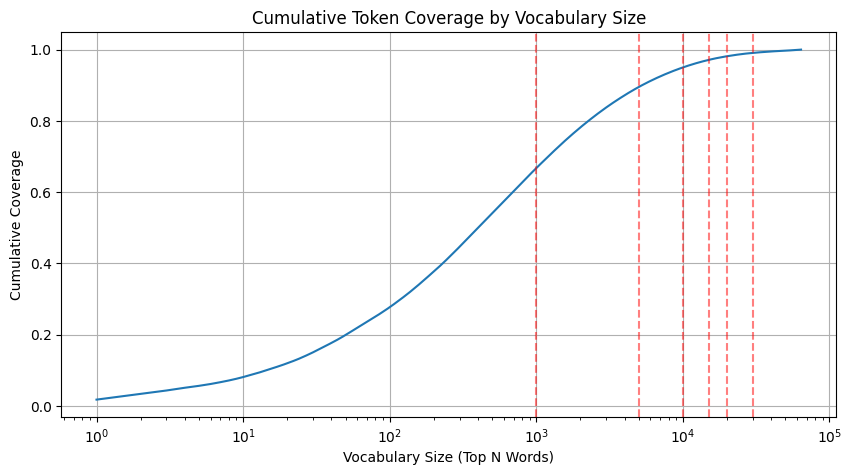

In [24]:
from itertools import accumulate

counts = [count for _, count in word_freq.most_common()]
cumulative_counts = list(accumulate(counts))
total_tokens = cumulative_counts[-1]

# O(1) : )
for n in [1000, 5000, 10000, 15000, 20000, 30000]:
    coverage = cumulative_counts[n - 1] / total_tokens
    print(f"Coverage with top {n} words: {coverage:.2%}")

counts = [count for _, count in word_freq.most_common()]
cumulative_counts = list(accumulate(counts))
total_tokens = cumulative_counts[-1]

# Normalize to percentage coverage
coverage = [count / total_tokens for count in cumulative_counts]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(coverage) + 1), coverage)
plt.xlabel("Vocabulary Size (Top N Words)")
plt.ylabel("Cumulative Coverage")
plt.title("Cumulative Token Coverage by Vocabulary Size")
for n in [1000, 5000, 10000, 15000, 20000, 30000]:
    plt.axvline(x=n, color='red', linestyle='--', alpha=0.5)
plt.grid(True)
plt.xscale('log')  # makes the curve easier to interpret
plt.show()

N-grams To generate or not to generate

Top Bigrams by Difference:
                   Positive  Negative      Diff
look    like          782.0    2236.0  0.000636
wast    time           72.0    1358.0  0.000554
one     best         1361.0     186.0  0.000487
worst   movi           18.0     900.0  0.000379
bad     movi          144.0     975.0  0.000359
one     worst          24.0     763.0  0.000318
ever    seen          772.0    1411.0  0.000285
highli  recommend     723.0      63.0  0.000274
movi    ever          510.0    1069.0  0.000247
        bad            84.0     638.0  0.000239
special effect        661.0    1186.0  0.000235
low     budget        485.0    1012.0  0.000233
must    see           616.0      86.0  0.000220
bad     act            48.0     553.0  0.000218
realli  bad            82.0     576.0  0.000213

Top Positive Bigrams:
                   Positive  Pos_Prop
one     best         1361.0  0.000567
watch   movi         1043.0  0.000434
even    though        875.0  0.000364
year    old           855.0  0

<Figure size 1200x600 with 0 Axes>

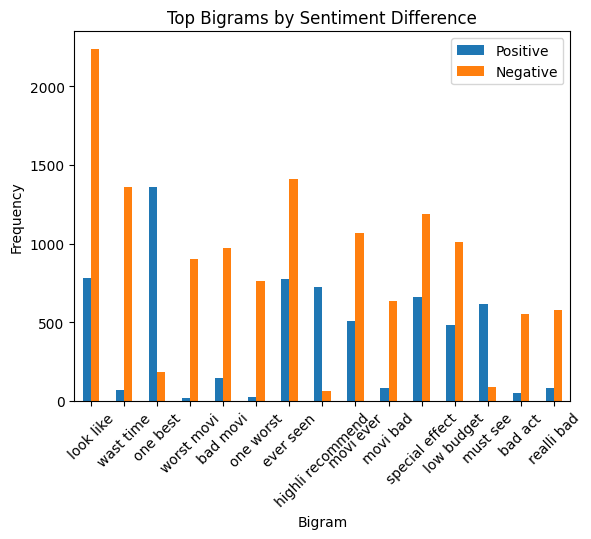

In [25]:
# Precompute tokens by label
positive_tokens = [t for row in train_processed[train_processed['label'] == 1]['processed_text'] for t in row]
negative_tokens = [t for row in train_processed[train_processed['label'] == 0]['processed_text'] for t in row]
all_tokens = positive_tokens + negative_tokens

# Function to get n-grams with frequency and difference
def analyze_ngrams(tokens_pos, tokens_neg, n, top_k=15):
    pos_ngrams = Counter(ngrams(tokens_pos, n))
    neg_ngrams = Counter(ngrams(tokens_neg, n))
    all_ngrams = Counter(ngrams(tokens_pos + tokens_neg, n))
    
    df_ngrams = pd.DataFrame({
        'Positive': dict(pos_ngrams),
        'Negative': dict(neg_ngrams),
        'Total': dict(all_ngrams)
    }).fillna(0)
    
    # Normalize
    pos_total = sum(pos_ngrams.values())
    neg_total = sum(neg_ngrams.values())
    df_ngrams['Pos_Prop'] = df_ngrams['Positive'] / pos_total
    df_ngrams['Neg_Prop'] = df_ngrams['Negative'] / neg_total
    
    # Absolute Difference  
    df_ngrams['Diff'] = (df_ngrams['Pos_Prop'] - df_ngrams['Neg_Prop']).abs()
    
    # Top by difference
    top_diff = df_ngrams.sort_values('Diff', ascending=False).head(top_k)
    top_pos = df_ngrams.sort_values('Pos_Prop', ascending=False).head(top_k)
    top_neg = df_ngrams.sort_values('Neg_Prop', ascending=False).head(top_k)
    
    return top_diff, top_pos, top_neg

# Bigrams
bigram_diff, bigram_pos, bigram_neg = analyze_ngrams(positive_tokens, negative_tokens, 2)
print("Top Bigrams by Difference:")
print(bigram_diff[['Positive', 'Negative', 'Diff']])
print("\nTop Positive Bigrams:")
print(bigram_pos[['Positive', 'Pos_Prop']])
print("\nTop Negative Bigrams:")
print(bigram_neg[['Negative', 'Neg_Prop']])

# Trigrams
trigram_diff, trigram_pos, trigram_neg = analyze_ngrams(positive_tokens, negative_tokens, 3)
print("\nTop Trigrams by Difference:")
print(trigram_diff[['Positive', 'Negative', 'Diff']])
print("\nTop Positive Trigrams:")
print(trigram_pos[['Positive', 'Pos_Prop']])
print("\nTop Negative Trigrams:")
print(trigram_neg[['Negative', 'Neg_Prop']])

# Visualize Top Bigrams by Difference
plt.figure(figsize=(12, 6))
bigram_diff[['Positive', 'Negative']].plot(kind='bar')
plt.title("Top Bigrams by Sentiment Difference")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.xticks(range(len(bigram_diff)), [f"{' '.join(x)}" for x in bigram_diff.index], rotation=45)
plt.show()

Overall the N-grams seem like they could be usefull in modeling the co-dependencies of tokens. YET since i am going to be testing sequential and Atention based models i would like to leave seeking these paterns to them in order to better evaluate their capabilities

***Vectorization***

In [26]:
preprocessor.build_vocabulary(train_processed['processed_text'], vocab_size=10000)

# Vectorize
train_vectors = preprocessor.vectorize(train_processed['processed_text'], max_length=300)
valid_vectors = preprocessor.vectorize(valid_processed['processed_text'], max_length=300)
test_vectors = preprocessor.vectorize(test_processed['processed_text'], max_length=300)

In [27]:
train_labels = np.array(train_processed['label'])
valid_labels = np.array(valid_processed['label'])
test_labels = np.array(test_processed['label'])

print(f"Train Vectors Shape: {train_vectors.shape}")
print(f"Valid Vectors Shape: {valid_vectors.shape}")
print(f"Test Vectors Shape: {test_vectors.shape}")
print(f"Train Labels Shape: {train_labels.shape}")

Train Vectors Shape: (40000, 300)
Valid Vectors Shape: (5000, 300)
Test Vectors Shape: (5000, 300)
Train Labels Shape: (40000,)


In [28]:
print(f"Max index in train_vectors: {train_vectors.max()}")
print(f"Max index in valid_vectors: {valid_vectors.max()}")
print(f"Max index in test_vectors: {test_vectors.max()}")

Max index in train_vectors: 10000
Max index in valid_vectors: 9998
Max index in test_vectors: 10000


In [29]:
#Pytorch tensors
train_data = TensorDataset(torch.tensor(train_vectors, dtype=torch.long), torch.tensor(train_labels, dtype=torch.long))
valid_data = TensorDataset(torch.tensor(valid_vectors, dtype=torch.long), torch.tensor(valid_labels, dtype=torch.long))
test_data = TensorDataset(torch.tensor(test_vectors, dtype=torch.long), torch.tensor(test_labels, dtype=torch.long))

In [30]:
torch.save(preprocessor.word_to_idx, 'Trained_models/vocab.pt')  # Save vocab

***Models***

In [31]:
from Models.LSTM import UnidirectionalLSTM  
from Models.BiLSTM import BidirectionalLSTM 
from Models.AttentionBasedModel import AttentionBasedModel
from Models.Text_cnn import TextCNN

from utils.Trainer import Trainer
from utils.Compare_models import ModelComparator

In [32]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [33]:
save_dir = "Trained_models"
os.makedirs(save_dir, exist_ok=True)

In [34]:
comparator = ModelComparator()

In [35]:
models = [
    ("Unidirectional LSTM", 
     UnidirectionalLSTM(vocab_size=10000, embedding_dim=100, hidden_dim=128, fc1_neurons=64, output_dim=2), 
     os.path.join(save_dir, "uni_lstm.pt")),
    ("Bidirectional LSTM", 
     BidirectionalLSTM(vocab_size=10000, embedding_dim=100, hidden_dim=128, fc1_neurons=128, fc2_neurons=64, output_dim=2), 
     os.path.join(save_dir, "bi_lstm.pt")),
    ("Attention-Based Model", 
     AttentionBasedModel(vocab_size=10000, embedding_dim=100, num_heads=4, num_layers=2, hidden_dim1=256, hidden_dim2=128, output_dim=2), 
     os.path.join(save_dir, "attn_model.pt")),
    ("TextCNN", 
     TextCNN(vocab_size=10000, embedding_dim=100, filter_sizes=[2, 3, 4, 5], num_filters=128, fc1_neurons=256, fc2_neurons=128, output_dim=2), 
     os.path.join(save_dir, "text_cnn.pt"))
]


In [37]:
for model_name, model, save_path in models:
    print(f"\nTraining {model_name}")
    start_time = time.time()
    trainer = Trainer(model, train_loader, valid_loader, test_loader, patience=7, save_path=save_path, epochs = 25, lr =0.001)
    trainer.train()
    end_time = time.time()
    train_losses, valid_losses, valid_accuracies, all_labels, all_preds, all_probs = trainer.get_metrics()
    comparator.add_model(model_name, train_losses, valid_losses, valid_accuracies, all_labels, all_preds, all_probs, end_time - start_time)


Training Unidirectional LSTM


Epoch 1/25
Train Loss: 0.6678
Valid Loss: 0.6158
Valid Accuracy: 0.6950
Saved best model to Trained_models/uni_lstm.pt


Epoch 2/25
Train Loss: 0.6276
Valid Loss: 0.5502
Valid Accuracy: 0.7462
Saved best model to Trained_models/uni_lstm.pt


Epoch 3/25
Train Loss: 0.4780
Valid Loss: 0.4376
Valid Accuracy: 0.7898
Saved best model to Trained_models/uni_lstm.pt


Epoch 4/25
Train Loss: 0.3885
Valid Loss: 0.3771
Valid Accuracy: 0.8356
Saved best model to Trained_models/uni_lstm.pt


Epoch 5/25
Train Loss: 0.3363
Valid Loss: 0.3235
Valid Accuracy: 0.8652
Saved best model to Trained_models/uni_lstm.pt


Epoch 6/25
Train Loss: 0.3005
Valid Loss: 0.3094
Valid Accuracy: 0.8728
Saved best model to Trained_models/uni_lstm.pt


Epoch 7/25
Train Loss: 0.2803
Valid Loss: 0.3003
Valid Accuracy: 0.8806
Saved best model to Trained_models/uni_lstm.pt


Epoch 8/25
Train Loss: 0.2632
Valid Loss: 0.3138
Valid Accuracy: 0.8778
No improvement for 1/7 epochs


Epoch 9/25
Train Loss: 0.2433
Valid Loss: 0.3250
Valid Accuracy: 0.8820
No improvement for 2/7 epochs


Epoch 10/25
Train Loss: 0.2351
Valid Loss: 0.2833
Valid Accuracy: 0.8882
Saved best model to Trained_models/uni_lstm.pt


Epoch 11/25
Train Loss: 0.2199
Valid Loss: 0.2779
Valid Accuracy: 0.8904
Saved best model to Trained_models/uni_lstm.pt


Epoch 12/25
Train Loss: 0.2113
Valid Loss: 0.2685
Valid Accuracy: 0.8932
Saved best model to Trained_models/uni_lstm.pt


Epoch 13/25
Train Loss: 0.2030
Valid Loss: 0.2894
Valid Accuracy: 0.8906
No improvement for 1/7 epochs


Epoch 14/25
Train Loss: 0.1935
Valid Loss: 0.2982
Valid Accuracy: 0.8902
No improvement for 2/7 epochs


Epoch 15/25
Train Loss: 0.1858
Valid Loss: 0.2926
Valid Accuracy: 0.8940
No improvement for 3/7 epochs


Epoch 16/25
Train Loss: 0.1761
Valid Loss: 0.2896
Valid Accuracy: 0.8946
No improvement for 4/7 epochs


Epoch 17/25
Train Loss: 0.1696
Valid Loss: 0.3247
Valid Accuracy: 0.8990
No improvement for 5/7 epochs


Epoch 18/25
Train Loss: 0.1642
Valid Loss: 0.3273
Valid Accuracy: 0.8962
No improvement for 6/7 epochs


Epoch 19/25
Train Loss: 0.1563
Valid Loss: 0.3030
Valid Accuracy: 0.8992
No improvement for 7/7 epochs
Early stopping triggered after 19 epochs


Test Accuracy: 0.8892

Training Bidirectional LSTM


Epoch 1/25
Train Loss: 0.3973
Valid Loss: 0.4046
Valid Accuracy: 0.8204
Saved best model to Trained_models/bi_lstm.pt


Epoch 2/25
Train Loss: 0.3318
Valid Loss: 0.3024
Valid Accuracy: 0.8758
Saved best model to Trained_models/bi_lstm.pt


Epoch 3/25
Train Loss: 0.2978
Valid Loss: 0.3442
Valid Accuracy: 0.8686
No improvement for 1/7 epochs


Epoch 4/25
Train Loss: 0.2728
Valid Loss: 0.2863
Valid Accuracy: 0.8908
Saved best model to Trained_models/bi_lstm.pt


Epoch 5/25
Train Loss: 0.2652
Valid Loss: 0.3050
Valid Accuracy: 0.8744
No improvement for 1/7 epochs


Epoch 6/25
Train Loss: 0.2440
Valid Loss: 0.2795
Valid Accuracy: 0.8896
Saved best model to Trained_models/bi_lstm.pt


Epoch 7/25
Train Loss: 0.2303
Valid Loss: 0.2733
Valid Accuracy: 0.8956
Saved best model to Trained_models/bi_lstm.pt


Epoch 8/25
Train Loss: 0.2153
Valid Loss: 0.3004
Valid Accuracy: 0.8938
No improvement for 1/7 epochs


Epoch 9/25
Train Loss: 0.2036
Valid Loss: 0.2665
Valid Accuracy: 0.8978
Saved best model to Trained_models/bi_lstm.pt


Epoch 10/25
Train Loss: 0.1954
Valid Loss: 0.2708
Valid Accuracy: 0.8982
No improvement for 1/7 epochs


Epoch 11/25
Train Loss: 0.1828
Valid Loss: 0.2917
Valid Accuracy: 0.8976
No improvement for 2/7 epochs


Epoch 12/25
Train Loss: 0.1747
Valid Loss: 0.2908
Valid Accuracy: 0.8926
No improvement for 3/7 epochs


Epoch 13/25
Train Loss: 0.1656
Valid Loss: 0.2624
Valid Accuracy: 0.8988
Saved best model to Trained_models/bi_lstm.pt


Epoch 14/25
Train Loss: 0.1600
Valid Loss: 0.2718
Valid Accuracy: 0.8928
No improvement for 1/7 epochs


Epoch 15/25
Train Loss: 0.1484
Valid Loss: 0.2977
Valid Accuracy: 0.9006
No improvement for 2/7 epochs


Epoch 16/25
Train Loss: 0.1425
Valid Loss: 0.2898
Valid Accuracy: 0.8954
No improvement for 3/7 epochs


Epoch 17/25
Train Loss: 0.1353
Valid Loss: 0.3109
Valid Accuracy: 0.8976
No improvement for 4/7 epochs


Epoch 18/25
Train Loss: 0.1296
Valid Loss: 0.2876
Valid Accuracy: 0.9008
No improvement for 5/7 epochs


Epoch 19/25
Train Loss: 0.1255
Valid Loss: 0.3318
Valid Accuracy: 0.8988
No improvement for 6/7 epochs


Epoch 20/25
Train Loss: 0.1203
Valid Loss: 0.3183
Valid Accuracy: 0.8906
No improvement for 7/7 epochs
Early stopping triggered after 20 epochs


Test Accuracy: 0.8908

Training Attention-Based Model


Epoch 1/25
Train Loss: 0.5232
Valid Loss: 0.4189
Valid Accuracy: 0.8132
Saved best model to Trained_models/attn_model.pt


Epoch 2/25
Train Loss: 0.3927
Valid Loss: 0.3646
Valid Accuracy: 0.8430
Saved best model to Trained_models/attn_model.pt


Epoch 3/25
Train Loss: 0.3423
Valid Loss: 0.3230
Valid Accuracy: 0.8668
Saved best model to Trained_models/attn_model.pt


Epoch 4/25
Train Loss: 0.3198
Valid Loss: 0.3216
Valid Accuracy: 0.8708
Saved best model to Trained_models/attn_model.pt


Epoch 5/25
Train Loss: 0.2944
Valid Loss: 0.3582
Valid Accuracy: 0.8558
No improvement for 1/7 epochs


Epoch 6/25
Train Loss: 0.2826
Valid Loss: 0.3050
Valid Accuracy: 0.8812
Saved best model to Trained_models/attn_model.pt


Epoch 7/25
Train Loss: 0.2720
Valid Loss: 0.3080
Valid Accuracy: 0.8780
No improvement for 1/7 epochs


Epoch 8/25
Train Loss: 0.2589
Valid Loss: 0.3185
Valid Accuracy: 0.8764
No improvement for 2/7 epochs


Epoch 9/25
Train Loss: 0.2506
Valid Loss: 0.3323
Valid Accuracy: 0.8810
No improvement for 3/7 epochs


Epoch 10/25
Train Loss: 0.2440
Valid Loss: 0.3032
Valid Accuracy: 0.8836
Saved best model to Trained_models/attn_model.pt


Epoch 11/25
Train Loss: 0.2395
Valid Loss: 0.3353
Valid Accuracy: 0.8836
No improvement for 1/7 epochs


Epoch 12/25
Train Loss: 0.2323
Valid Loss: 0.3157
Valid Accuracy: 0.8872
No improvement for 2/7 epochs


Epoch 13/25
Train Loss: 0.2255
Valid Loss: 0.3968
Valid Accuracy: 0.8814
No improvement for 3/7 epochs


Epoch 14/25
Train Loss: 0.2212
Valid Loss: 0.3262
Valid Accuracy: 0.8852
No improvement for 4/7 epochs


Epoch 15/25
Train Loss: 0.2163
Valid Loss: 0.3179
Valid Accuracy: 0.8872
No improvement for 5/7 epochs


Epoch 16/25
Train Loss: 0.2131
Valid Loss: 0.3704
Valid Accuracy: 0.8846
No improvement for 6/7 epochs


Epoch 17/25
Train Loss: 0.2081
Valid Loss: 0.3808
Valid Accuracy: 0.8832
No improvement for 7/7 epochs
Early stopping triggered after 17 epochs


Test Accuracy: 0.8774

Training TextCNN


Epoch 1/25
Train Loss: 0.6042
Valid Loss: 0.4151
Valid Accuracy: 0.8100
Saved best model to Trained_models/text_cnn.pt


Epoch 2/25
Train Loss: 0.4218
Valid Loss: 0.3556
Valid Accuracy: 0.8508
Saved best model to Trained_models/text_cnn.pt


Epoch 3/25
Train Loss: 0.3721
Valid Loss: 0.3210
Valid Accuracy: 0.8588
Saved best model to Trained_models/text_cnn.pt


Epoch 4/25
Train Loss: 0.3423
Valid Loss: 0.3084
Valid Accuracy: 0.8656
Saved best model to Trained_models/text_cnn.pt


Epoch 5/25
Train Loss: 0.3241
Valid Loss: 0.2973
Valid Accuracy: 0.8714
Saved best model to Trained_models/text_cnn.pt


Epoch 6/25
Train Loss: 0.3119
Valid Loss: 0.2885
Valid Accuracy: 0.8748
Saved best model to Trained_models/text_cnn.pt


Epoch 7/25
Train Loss: 0.2978
Valid Loss: 0.2871
Valid Accuracy: 0.8746
Saved best model to Trained_models/text_cnn.pt


Epoch 8/25
Train Loss: 0.2881
Valid Loss: 0.2814
Valid Accuracy: 0.8768
Saved best model to Trained_models/text_cnn.pt


Epoch 9/25
Train Loss: 0.2757
Valid Loss: 0.2772
Valid Accuracy: 0.8818
Saved best model to Trained_models/text_cnn.pt


Epoch 10/25
Train Loss: 0.2662
Valid Loss: 0.2720
Valid Accuracy: 0.8832
Saved best model to Trained_models/text_cnn.pt


Epoch 11/25
Train Loss: 0.2598
Valid Loss: 0.2732
Valid Accuracy: 0.8832
No improvement for 1/7 epochs


Epoch 12/25
Train Loss: 0.2526
Valid Loss: 0.2705
Valid Accuracy: 0.8866
Saved best model to Trained_models/text_cnn.pt


Epoch 13/25
Train Loss: 0.2455
Valid Loss: 0.2685
Valid Accuracy: 0.8862
Saved best model to Trained_models/text_cnn.pt


Epoch 14/25
Train Loss: 0.2370
Valid Loss: 0.2699
Valid Accuracy: 0.8864
No improvement for 1/7 epochs


Epoch 15/25
Train Loss: 0.2325
Valid Loss: 0.2687
Valid Accuracy: 0.8860
No improvement for 2/7 epochs


Epoch 16/25
Train Loss: 0.2262
Valid Loss: 0.2697
Valid Accuracy: 0.8844
No improvement for 3/7 epochs


Epoch 17/25
Train Loss: 0.2202
Valid Loss: 0.2774
Valid Accuracy: 0.8826
No improvement for 4/7 epochs


Epoch 18/25
Train Loss: 0.2149
Valid Loss: 0.2759
Valid Accuracy: 0.8840
No improvement for 5/7 epochs


Epoch 19/25
Train Loss: 0.2097
Valid Loss: 0.2755
Valid Accuracy: 0.8858
No improvement for 6/7 epochs


Epoch 20/25
Train Loss: 0.2060
Valid Loss: 0.2738
Valid Accuracy: 0.8862
No improvement for 7/7 epochs
Early stopping triggered after 20 epochs


Test Accuracy: 0.8888



Model Comparison Summary:
                   Model  Test Accuracy       AUC  Final Train Loss  \
0    Unidirectional LSTM         0.8892  0.957346          0.156338   
1     Bidirectional LSTM         0.8908  0.957248          0.120297   
2  Attention-Based Model         0.8774  0.955296          0.208097   
3                TextCNN         0.8888  0.954332          0.206024   

   Final Valid Loss  Final Valid Accuracy  Training Time (s)  
0          0.303037                0.8992         223.807562  
1          0.318324                0.8906         474.155251  
2          0.380835                0.8832         380.587172  
3          0.273805                0.8862         172.972907  


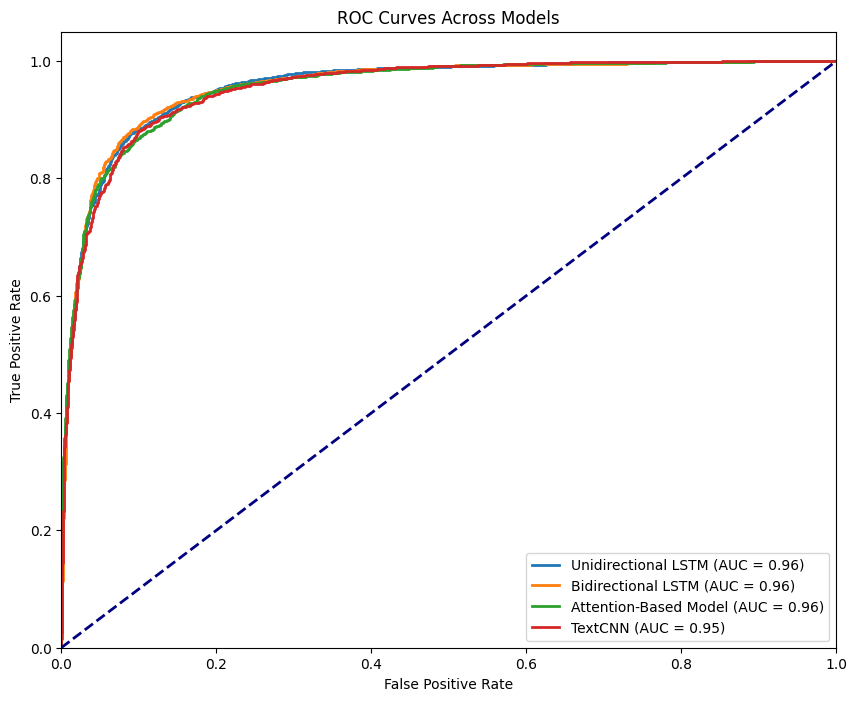

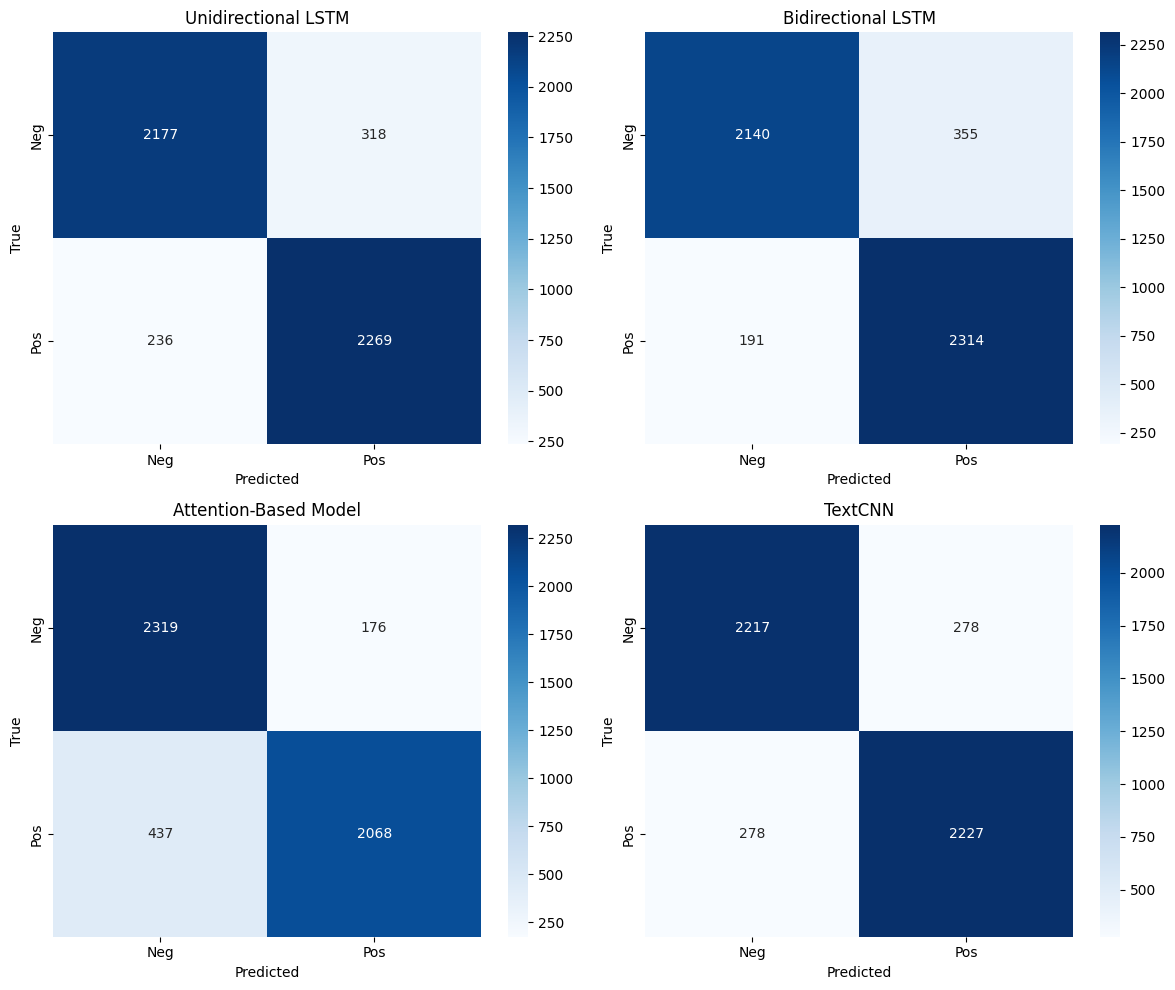

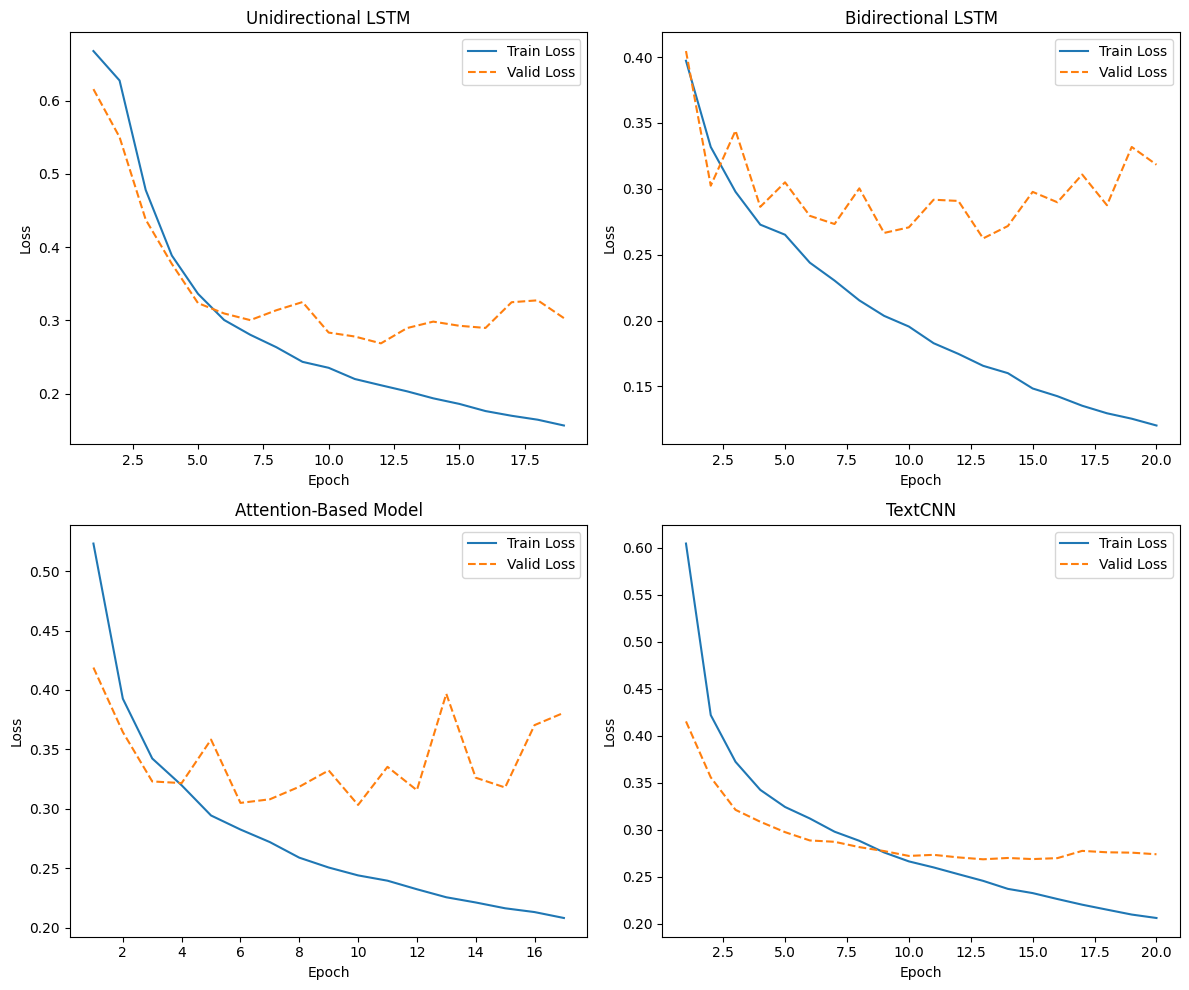

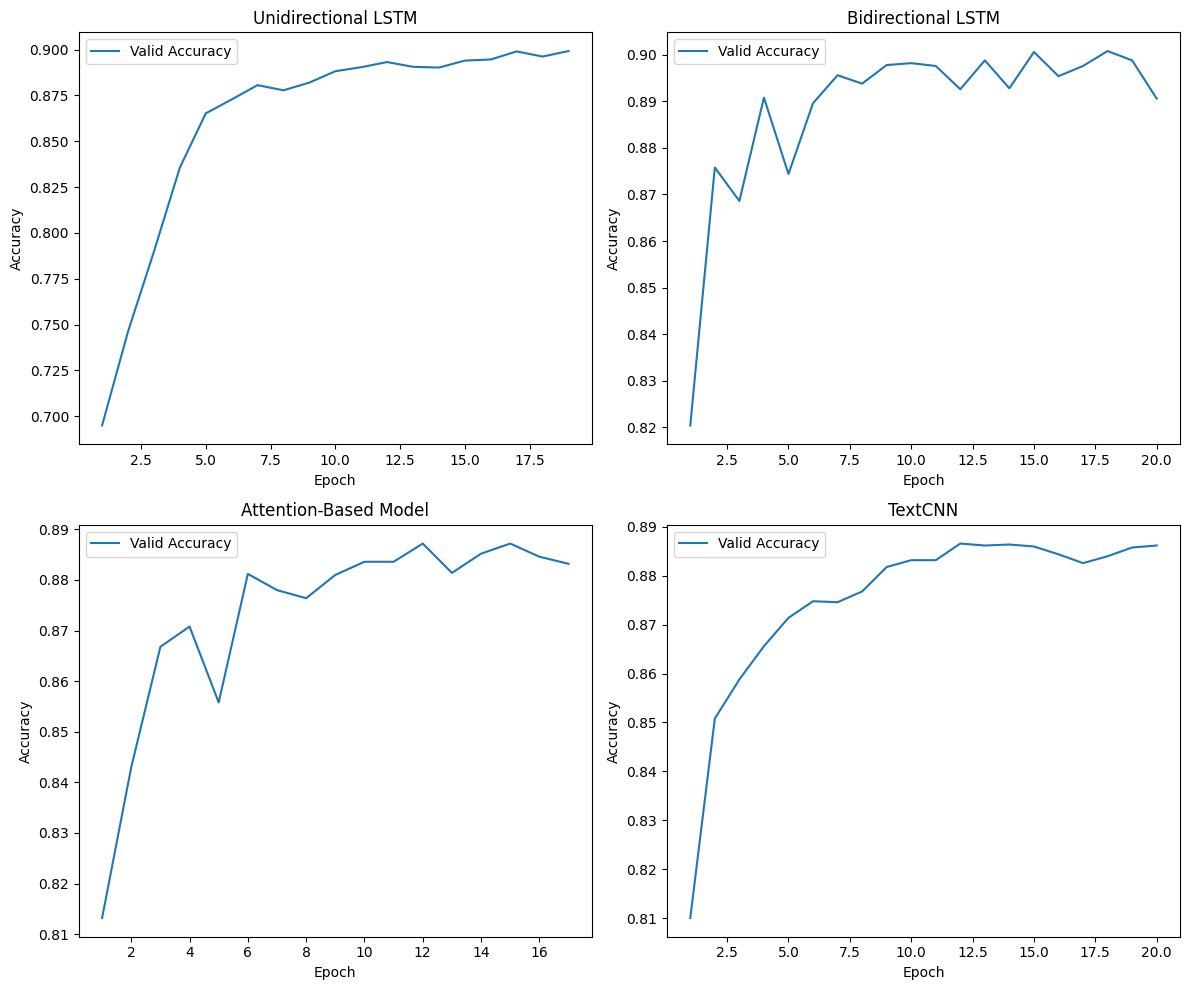

In [38]:
summary_table=comparator.plot_all()     

In [39]:
summary_table

,Model,Test Accuracy,AUC,Final Train Loss,Final Valid Loss,Final Valid Accuracy,Training Time (s)
0,Unidirectional LSTM,0.8892,0.957346,0.156338,0.303037,0.8992,223.807562
1,Bidirectional LSTM,0.8908,0.957248,0.120297,0.318324,0.8906,474.155251
2,Attention-Based Model,0.8774,0.955296,0.208097,0.380835,0.8832,380.587172
3,TextCNN,0.8888,0.954332,0.206024,0.273805,0.8862,172.972907
